In [7]:
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
colors =plt.get_cmap('plasma')

In [11]:
def compute_ft_score(df):
    grouped = df.groupby('feature')['correlation'].value_counts().unstack(fill_value=0)
    #if negartive in the column, multiply by -5, if positive, multiply by 5, if unclear, multiply by 0

    if "negative" in grouped.columns:
        grouped["negative"] = grouped["negative"] * -1
    if "positive" in grouped.columns:
        grouped["positive"] = grouped["positive"] * 1
    if "unclear correlation" in grouped.columns:
        grouped["unclear correlation"] = grouped["unclear correlation"] * 0

    grouped["ft_score"] = abs(grouped.sum(axis=1)/5)
    return grouped

def get_ft_scores(experiment):
    tasks = ["OMS","PLD","TOX","SOL","UFL"]
    datapath = "data_rd3/computed_results"
    results = {}
    stds = {}

    for task in tasks:
        #open xlsx file
        xl_file = f"{task}/{task}_correlation_analysis.xlsx"
        df = pd.read_excel(os.path.join(datapath, xl_file), sheet_name=experiment)
        #convert fearure names to lower case
        df = df.dropna()
        df["feature"] = df["feature"].str.lower()
        df = df[["feature", "correlation"]]

        df_fts = compute_ft_score(df)
        task_score = df_fts["ft_score"].mean(axis=0)
        results[task] = task_score
        stds[task] = df_fts["ft_score"].std(axis=0)
    return results, stds


In [12]:
experiment = "baseline"
results_baseline, std_baselines = get_ft_scores(experiment)
print(np.mean(list(results_baseline.values())))

experiment = "xpert"
results_xpert,std_xpert = get_ft_scores(experiment)
print(np.mean(list(results_xpert.values())))


0.4083787878787879
0.3586666666666666


In [13]:
results_baseline

std_baselines


{'OMS': 0.1572490786213793,
 'PLD': 0.4406606610327477,
 'TOX': 0.27294688127912364,
 'SOL': 0.42175678759065377,
 'UFL': 0.3893013685508382}

/var/folders/3j/w7mmc2y12pddlxs19kfr_6lc0000gn/T/ipykernel_52467/1446551158.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


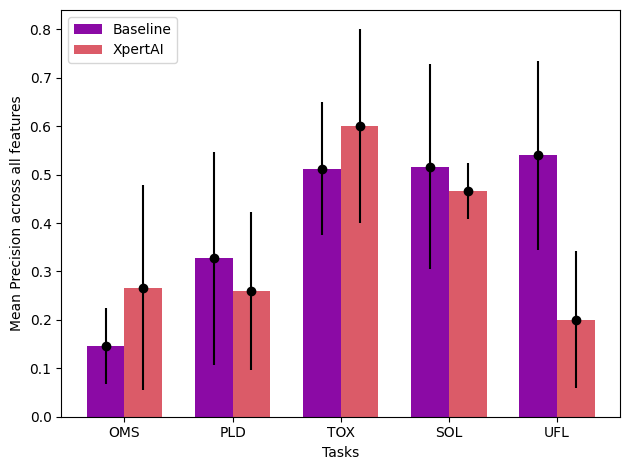

In [15]:

#plot results_baseline and results_xpert as bars next to each other
cmap = plt.get_cmap('plasma')
colors = ["#5402a3", "#8b0aa5", "#b93389","#db5b68","#febc2b" ]
fig, ax = plt.subplots()
width = 0.35

x = np.arange(len(results_baseline))
bar1 = ax.bar(x - width/2, list(results_baseline.values()), width, label='Baseline',color=colors[1],)
bar2 = ax.bar(x + width/2, list(results_xpert.values()), width, label='XpertAI',color=colors[3])
#add error bars
for i, (key, value) in enumerate(results_baseline.items()):
    ax.errorbar(i - width/2, value, yerr=std_baselines[key]/2, fmt='o',color='black')
    ax.errorbar(i + width/2, results_xpert[key], yerr=std_xpert[key]/2, fmt='o',color='black')
ax.legend(loc='upper left')
ax.set_xticks(x)
ax.set_xticklabels(results_baseline.keys())
ax.set_xlabel('Tasks')
ax.set_ylabel('Mean Precision across all features')
fig.tight_layout()
fig.savefig("ft_scores_comparison.png")
fig.show()

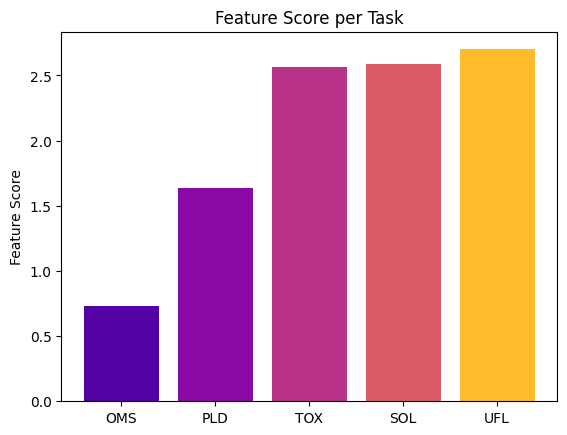

In [7]:
#bar plor for each task
cmap = plt.get_cmap('plasma')
colors = ["#5402a3", "#8b0aa5", "#b93389","#db5b68","#febc2b" ]

fig, ax = plt.subplots()
ax.bar(results.keys(), results.values(), color=colors )
plt.ylabel('Feature Score')
plt.title('Feature Score per Task')
plt.savefig(f"data_rd3/computed_results/{experiment}feature_score.png")
plt.show()

1.3333333333333333

In [34]:
task = "UFL"
xl_file = f"{task}/{task}_correlation_analysis.xlsx"
print(f"Processing {xl_file}")
df = pd.read_excel(os.path.join(datapath, xl_file), sheet_name="Sheet1")
df = df.dropna()
df = df[["feature", "correlation"]]
grouped = df.groupby('feature')['correlation'].value_counts().unstack(fill_value=0)



Processing UFL/UFL_correlation_analysis.xlsx


In [35]:
grouped

correlation,positive,unclear correlation
feature,,
Dipole Moment,3,2
Information Content Index,0,1
Label Information Content Index,0,2
Structural Information Content Index,2,3
Topological Descriptors,0,1


In [ ]:
metric = 'meteor'
liac = ['#febc2b','#f48849','#db5b68','#b93389','#8b0aa5','#939393']
labels = ['Task 1','Task 2','Task 3','Task 4','Task 5','Mean']
exp_types = ["xpertai", "baseline"]
titles = ['XpertAI explanations','ChatGPT explanations']
fig, axes = plt.subplots(1, 2, sharey=True,figsize=(8,4))
axs = axes.ravel()
num_bars = len(labels)
for n,exp_type in enumerate(exp_types):
    hts, los,his = get_data(exp_type)
    title = titles[n]

    axs[n].bar(np.arange(num_bars), hts)
    #axs[n].scatter(np.arange(5), hts,color='k',marker='o')
    #axs[n].plot(np.arange(5), hts,color='k',ls='--')
    axs[n].set_xticks(np.arange(num_bars),labels,fontsize='small')

    for i, p in enumerate(axs[n].patches):
        x = p.get_x()  # get the bottom left x corner of the bar
        w = p.get_width()  # get width of bar
        h = p.get_height()
        p.set_color(c=liac[i])
        min_y = los[i]
        max_y = his[i]
        axs[n].vlines(x+w/2, min_y, max_y, color='k')
        axs[n].hlines(min_y,x+w/2-w/8,x+w/2+w/8,color='k')
        axs[n].hlines(max_y,x+w/2-w/8,x+w/2+w/8,color='k')

    axs[n].set_xlabel('Case study')
    
    axs[n].set_title(f'{title}',fontsize='medium')
    
axs[0].set_ylabel(f'{metric.capitalize()} score')
fig.savefig(f'data_rd3/computed_results/xpertai_vs_baseline_average_{metric}.png',facecolor='white',bbox_inches='tight',dpi=300)
fig.show()

In [ ]:
scores = {"negative": -5, "positive": 5, "unclear correlation": 0}
ntrials = 5
tot_scores = [] 
for i in range(len(grouped)):
    #multiply the count of each correlation type by the score
    #print(grouped.iloc[i])
    row_score = grouped.iloc[i].values  * [-5, 5, 0]
    ft_score = abs(row_score.sum()/ntrials)
    tot_scores.append(ft_score)
    print(f"Feature: {grouped.iloc[i].name} Score: {ft_score}")

print(np.array(tot_scores).mean()) #sum the scores
    
    #print(grouped.iloc[i].name, grouped.iloc[i].values)

In [ ]:
#print max value of each feature and the label
max_values = grouped.max(axis=1).to_dict()
max_fts = grouped.idxmax(axis=1).to_dict()

results = {"No agreement":0, "Partial agreement":0, "Full agreement":0}
for ft, v in max_values.items():
    if v == 2:
        results["No agreement"] += 1 
    elif v == 3:
        results["Partial agreement"] += 1
    elif v>=4:
        results["Full agreement"] += 1
 

In [ ]:
#plot the results dict as a pie chart
#set colors
colors = sns.color_palette("pastel")
fig, ax = plt.subplots()
ax.pie(results.values(), labels=results.keys(), autopct='%1.1f%%', colors=colors)
ax.axis('equal')
plt.title(f"Agreement in {task} task")
plt.show()




In [ ]:
results
#plot results


In [ ]:
results

In [ ]:
#plot the number of features with a certain correlation value
grouped.plot(kind='bar', stacked=True, figsize=(10,5))
